# The Community Matching Problem
by Dani Roytburg.

Email [d.j.roytburg@emory.edu](d.j.roytburg@emory.edu) or [djroytburg@gmail.com](djroytburg@gmail.com) with questions.

This notebook is supposed to provide more tools to help us figure out how to match communities across time bins.

## 0. Setup

Run the cells below.

In [2]:
import pickle
import pandas as pd
from networkx.utils.union_find import UnionFind
    
# This function returns two lists of dictionaries.
#1. atoc (author to community) -- the index of the list aligns to the bin id's [0-6], the \
#   keys of each dictionary are twitter handles and the values are communities. e.g.: atoc[0]['katierooze']
#   
#2. ctoa (community to authors) -- index of the list is the same, \
#   keys are communities and values are sets of all authors affiliated with that community.
def AtoC():
    atoc = list()
    ctoa = list()
    for i in range(0, 7):
        df = pd.read_csv(f"community_data/communities/bin{i}_communities.csv")
        atoc.append(dict(zip(df['name'], df['community'])))
        searches = set(df['community'].value_counts().index)
        ctoa.append({search: set(df[df['community'] == search]['name']) for search in searches})
    return atoc, ctoa

atoc, ctoa = AtoC()

In [3]:
# Based off of AtoC (author to community), we can track someone's presence in communities over time. \

def author_communities(atoc, name, labels = False):
    if labels:
        return [("T" + str(i) + "C" + str(atoc[i][name]) if name in atoc[i] else None) for i in range(0,7)]
    return [(atoc[i][name.lower()] if name.lower() in atoc[i] else None) for i in range(0,7)]

author_communities(atoc, 'kanyewest', labels = True)

['T0C3', 'T1C9', 'T2C7', 'T3C5', 'T4C7', 'T5C1', 'T6C4']

## 1. What's the Problem?

The algorithm that we used to process the communities (louvain clustering) does not have a built in time-series component. Our data stretches from 2014 to 2020. We've made six "slices" in the data, which produces seven "bins" of Twitter data. (labelled bin0-bin6 or T0-T6). This means that the communities in each set of tweets are formed **completely** independent of eachother. To illustrate this, let's use an analogy...

<div>
   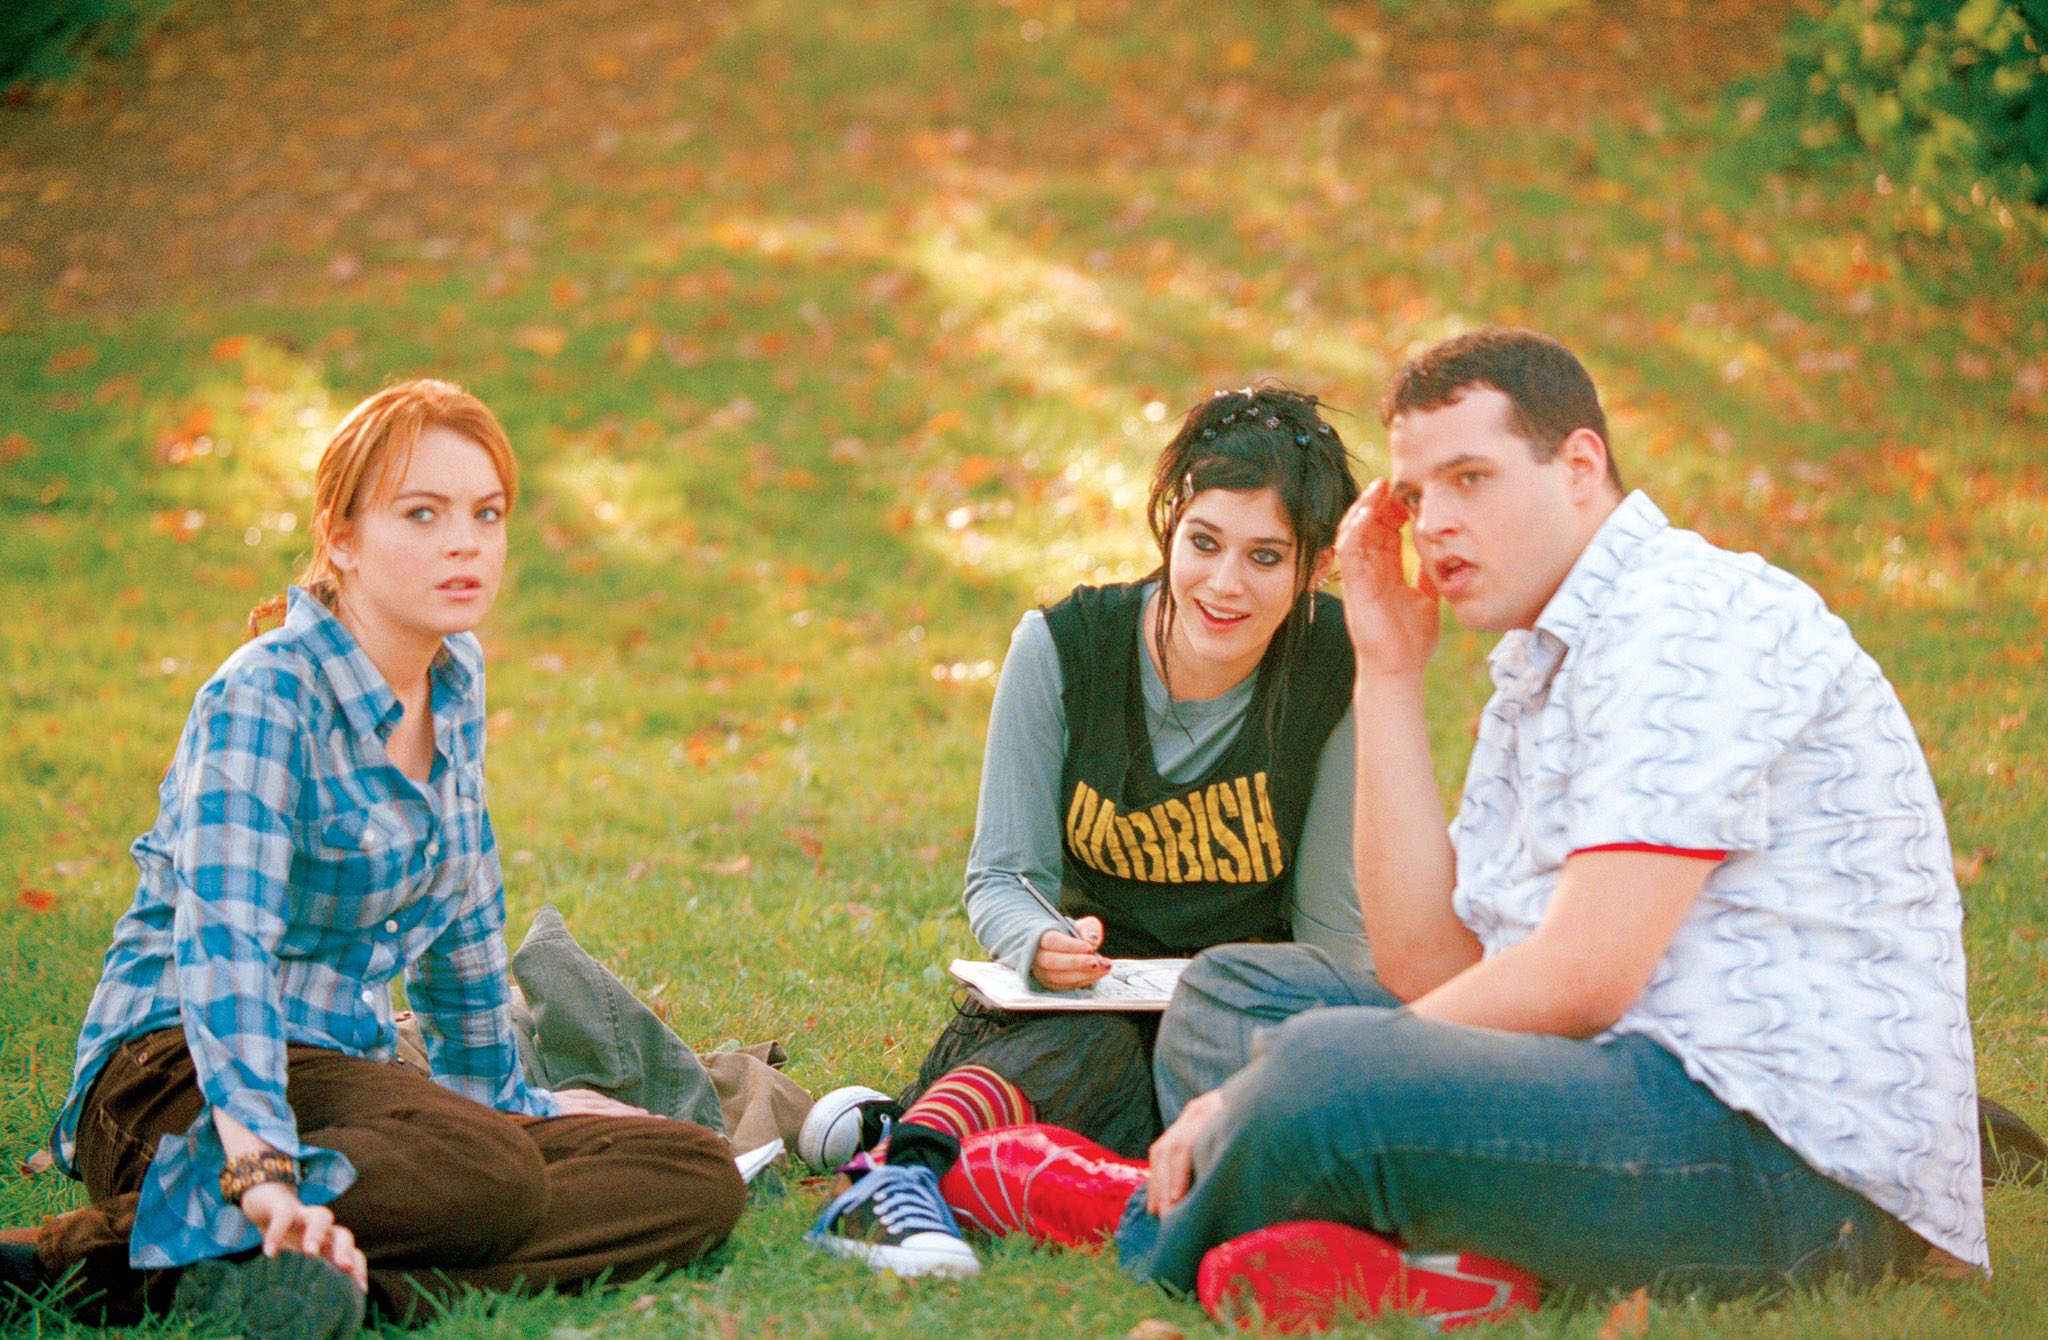
</div>

Say that you are a high school teacher who has taught for seven years. Over the course of those seven years, you know generally how students in class group together and socialize. To paraphrase Mean Girls, you might have 'geeks,' who can be sub-classified as band kids or science olympiad nerds or debaters; you might have 'jocks' that can be sub-classified according to their athletic prestige (JV v. Varsity), by type of sport, or any other relatively arbitrary dividing line; you might have popular students who naturally cluster on their own. Assume also that you teach classrooms which merge all the grades together. 

After the first year, you have your "clusters" built from your observations of how students interact with eachother. But, after the second year, the classroom looks very different and only has ~20-30% of the students you're familiar with. Again, you cluster these kids into groups, again formed by your observations of their behavior. 

However, you've noticed a few changes. It seems like too many band kids graduated, so the remaining band kids are dispersed throughout the geeks and they no longer hang out together. Also, the popular group from last year split, but they still only hang out in their respective factions plus some freshman newcomers. You can still kind of make out which community is which based on the major players that you recognize, but if you didn't have this information you would have no clue of, say, the band kid community that dissipated by year 2.

Over the course of seven years, the general "communities" that your teacherly intuition creates get challenged and become completely unrecognizable before coming back together again.

Now, imagine that every year has several hundred thousand students, the vast majority of whom have only one or two interactions with other people. To make things easier, you strive to make optimal clusters out of the top 50 communities and forget anybody that isn't really tied to them. You also have about a million interactions between two students to parse through, and the only thing you have are records of socializing that only tell you the two interlocutors' names.

Finally, at the end of year 7, the principal expresses their interest in the community clustering experiment that you  once called a classroom. Using the 350 total communities that you've discovered (50 communities per year for seven years), find 6 or 7 communities that persist in one form or another. Of course, at some point there are no similarities between the students from year 1 and year 7, so you'll need to chain together each community based on your best guess of what it looks like by year.

## 2. Metrics of Evaluation

### Seed Persistence

As we discussed, the communities are "seeded", which means that we cluster them naturally together to see where they go. We have defined a set of 59 users who, using qualitiative scholarship, can be assumed to belong within a particular community. This is helpful for creating good communities, but it also can be helpful to validate the quality of our results. For example, let's look at seed 4 (these are the conservatives):

In [4]:
seeds = pd.read_csv("seeds.csv")
seeds.columns = ['name','community']
seed_communities = {i: set(seeds[seeds['community'] == i]['name']) for i in set(seeds['community'].value_counts().index)}
for author in seed_communities[4]:
    print(f"{author}: {author_communities(atoc, author)}")

waynedupreeshow: [4, 5, 4, 0, 10, 18, 4]
gopblackchick: [4, 5, 4, 0, 10, None, None]
theblaze: [4, 5, 4, 0, 10, 18, 5]
washtimes: [4, 5, 4, 0, 10, 18, 4]
amymek: [4, 5, 4, 0, 10, 18, 5]
seanhannity: [4, 5, 4, 0, 10, 18, 5]
patdollard: [4, 5, 4, 0, 10, None, None]
foxnews: [4, 5, 4, 0, 10, 18, 4]
larryelder: [4, 5, 4, 0, 10, 18, 4]


Look how consistent it is! This isn't always the case though:

In [5]:
#for author in seed_communities[3]:
    #print(f"{author}: {author_communities(atoc, author)}")

def make_seed_df(seedcom, atoc):
    authors = seed_communities[seedcom]
    cols = ['name']
    for i in range(0, 7):
        cols.append(f'T{i}')
    seed_three = pd.DataFrame(columns = cols)
    seed_three['name'] = pd.Series(author for author in authors)
    for i in range(0, 7):
        Ti = [author_communities(atoc, author)[i] for author in authors]
        seed_three[f'T{i}'] = Ti
    return seed_three

make_seed_df(4, atoc) # The good news is that we've already located the conservative community. Look how persistent the seeds are!


,name,T0,T1,T2,T3,T4,T5,T6
0,waynedupreeshow,4,5,4,0,10,18.0,4.0
1,gopblackchick,4,5,4,0,10,NaN,NaN
2,theblaze,4,5,4,0,10,18.0,5.0
3,washtimes,4,5,4,0,10,18.0,4.0
4,amymek,4,5,4,0,10,18.0,5.0
5,seanhannity,4,5,4,0,10,18.0,5.0
6,patdollard,4,5,4,0,10,NaN,NaN
7,foxnews,4,5,4,0,10,18.0,4.0
8,larryelder,4,5,4,0,10,18.0,4.0


In [6]:
make_seed_df(6, atoc) # This isn't always the case.

,name,T0,T1,T2,T3,T4,T5,T6
0,commonblackgiri,NaN,3.0,6.0,7.0,15.0,NaN,NaN
1,igivebootyrubs,NaN,2.0,NaN,NaN,NaN,NaN,NaN
2,ultralightskin,NaN,2.0,NaN,NaN,NaN,NaN,NaN
3,drugfambeezy,38.0,NaN,NaN,NaN,NaN,NaN,NaN
4,hbcufessions,9.0,2.0,6.0,5.0,5.0,5.0,25.0
5,ikeepittooreal,3.0,2.0,9.0,15.0,5.0,NaN,NaN
6,freetopher,3.0,2.0,NaN,NaN,NaN,NaN,NaN
7,bestcomedyvine,NaN,2.0,6.0,1.0,21.0,NaN,NaN
8,jabarithegreat,NaN,2.0,24.0,NaN,NaN,NaN,NaN


### Jaccard Scores

One good method for doing this work is to use Jaccard scores. A Jaccard score looks at two **non-mutually exclusive** communities (meaning they have some common nodes). Professor Dean Freelon, who designed the Python wrapper we use for community clustering, implemented the Jaccard score computation for a very similar project on the [War in Syria](https://journals.sagepub.com/doi/abs/10.1177/0002716214563921). A Jaccard score is a very simple calculation; it is the number of shared nodes across the two communities divided by the number of members in either community. A weighted Jaccard score measures this with respect to in-degree.

$\begin{align}
\text{weighted_jaccard()} = \frac{\sum A_i \cap B_j}{\sum A_i \cup B_j}
\end{align}$

I've already computed all of the possible jaccard score combinations and saved them into this notebook. Run the code cell below.

In [7]:
with open(b"50_comm_scores.pkl", "rb") as f:
    jaccards = pickle.load(f)

The 'jaccards' data object can be a little bit tricky to navigate. 'jaccards' is a list, like AtoC and CtoA. However, it goes from 0 to 5 as opposed to the usual 0 to 7. This is because the jaccard function Freelon uses returns a custom "Match" object. This match object tracks the relationship of $T_i \times T_{i+1}$. For instance, if you want to compare communities 2 and 3, you would use jaccards[2]. I did not calculate jaccard scores for bins that were not next to eachother, because I did not think that this made sense in light of how we have defined and understood continuity. 

Ok. Let's look at the Match object:

In [8]:
zero_to_one = jaccards[0] # this is the Match object between time bins 0 and 1.

zero_to_one.best_matches # best_matches takes every community in T0 \
                         # and finds the community in T1 that yields the highest Jaccard score.

OrderedDict([('0x4', 0.2462),
             ('10x1', 0.5091),
             ('113x', 0),
             ('1252x', 0),
             ('12x0', 0.169),
             ('13x17', 0.1218),
             ('14x0', 0.0339),
             ('150x', 0),
             ('153x', 0),
             ('15x11', 0.3805),
             ('160x113', 0.036),
             ('16x5', 0.1707),
             ('17x19', 0.3109),
             ('18x63', 0.085),
             ('191x', 0),
             ('1955x', 0),
             ('19x8', 0.0013),
             ('1x2', 0.1404),
             ('20x21', 0.0141),
             ('21x6', 0.0011),
             ('22x14', 0.2984),
             ('24x4', 0.002),
             ('25x10', 0.0509),
             ('27x0', 0.0001),
             ('29x26', 0.0269),
             ('2x2', 0.3126),
             ('31x29', 0.0089),
             ('32x26', 0.0056),
             ('331x', 0),
             ('34x3', 0.0021),
             ('35x', 0),
             ('37x514', 0.1142),
             ('38x', 0),
             (

In [9]:
zero_to_one.shared_nodes # This returns all of the users who are in both matched communities. Note that \
                         #  Freelon's package filters out a large percentage of users who constitute \
                         #  the long tail of rare interactions. This means you might find users in AtoC or \
                         #  CtoA not present in shared_nodes

OrderedDict([('10x1',
              {'10thamendment',
               '20committee',
               '2anow',
               '2nd_to_none',
               '550ktrs',
               'abcnews',
               'actlightning',
               'afederalfarmer',
               'ag_conservative',
               'ahmalcolm',
               'alfonzorachel',
               'allenwest',
               'alsharpton_rev',
               'alvedaking',
               'americanglob',
               'amronsomar',
               'amymek',
               'andersondrlja',
               'andreatantaros',
               'anna12061',
               'anncoulter',
               'anonymousliberi',
               'anthonycumia',
               'appsame',
               'april_mg',
               'aridavidusa',
               'aswoyer',
               'athudd',
               'atomiktiger',
               'backatone000',
               'barackobama',
               'barneyfranken',
               'barry_o44',
     

In [10]:
[jaccards[i].convergences for i in range(0, 6)] # jaccards.convergences tracks where communities converge. \
                                                #  The first value is from the *second* time bin, the list \
                                                #  or the second value are the two communities that converged.

[OrderedDict(),
 OrderedDict([('0', ['0', '6'])]),
 OrderedDict(),
 OrderedDict(),
 OrderedDict(),
 OrderedDict()]

In [11]:
import tsm
 
def get_convergences(self: tsm.cMatchObject, threshold = 0.10):
    convergences = dict()
    scores = [score for score in self.best_matches.values()]
    strings = [(string.split("x")[0], string.split("x")[1]) for string in self.best_matches.keys()]
    comm1 = [string for string, _ in strings]
    comm2 = [string for _, string in strings]
    for a, b, score in zip(comm1, comm2, scores):
        if score > threshold:
            if b not in convergences:
                convergences[b] = {a}
            else:
                convergences[b].add(a)
    end = dict()
    for second, firsts in convergences.items():
        if len(firsts) > 1:
            end[second] = firsts
        
    return end


tsm.cMatchObject.get_convergences = get_convergences
[jacc.get_convergences() for jacc in jaccards]

def get_divergences(self: tsm.cMatchObject, threshold = 0.10):
    divergences = dict()
    alls = self.nonzero_jaccs
    for comm in alls:
        commi = alls[comm]
        for split, score in commi.items():
            if score > threshold:
                if comm not in divergences:
                    divergences[comm] = {split}
                else:
                    divergences[comm].update(split)
    end = dict()
    for ki, diverge in divergences.items():
        if len(diverge) > 1:
            end[ki] = diverge
    return end
                    


tsm.cMatchObject.get_divergences = get_divergences
[jacc.get_divergences() for jacc in jaccards]

[{'1': {'0', '2'}, '3': {'6', '7'}, '5': {'2', '8'}},
 {'0': {'0', '3'}, '2': {'2', '3'}, '4': {'4', '9'}, '8': {'20', '8'}},
 {},
 {'12': {'2', '30', '5'},
  '27': {'1', '12', '8'},
  '28': {'4', '5', '52'},
  '31': {'0', '2', '20', '6', '7'}},
 {'2': {'3', '7'}},
 {'3': {'3', '4'}, '8': {'1', '18', '4'}}]

In [12]:
[jaccards[i].divergences for i in range(0, 6)] # Just like above but backwards

[OrderedDict(),
 OrderedDict(),
 OrderedDict(),
 OrderedDict(),
 OrderedDict(),
 OrderedDict()]

In [13]:
jaccards[0].nonzero_jaccs['0'] # Lastly, if you want to see the full Jaccard scores they are available in this format.

{'4': 0.2462,
 '26': 0.0001,
 '11': 0.0002,
 '12': 0.0005,
 '5': 0.0041,
 '16': 0.0014,
 '514': 0.0034,
 '19': 0.0017,
 '24': 0.0056,
 '2': 0.0357,
 '0': 0.0197,
 '35': 0.0001,
 '9': 0.0001,
 '6': 0.0462,
 '7': 0.0803,
 '1': 0.0009,
 '419': 0.0,
 '23': 0.0007,
 '3': 0.0146,
 '25': 0.0021,
 '91': 0.0001,
 '18': 0.0117,
 '8': 0.0038,
 '48': 0.0001,
 '21': 0.0001,
 '14': 0.0005}

## 3. Matching Algorithms

In [45]:
def dynamic_sequential_matching(jaccards, threshold = 0.2):
    j = 0
    ctoo = dict()
    community_pool = dict()
    for i in range(len(jaccards)):
        jacc = jaccards[i]
        passed = {k: v for k, v in jacc.best_matches.items() if v > threshold}
        for key, val in passed.items():
            j += 1
            Ti, Tj = (key.split("x")[0], key.split("x")[1])
            kTi, kTj = f"T{i}_C{Ti}", f"T{i+1}_C{Tj}"
            if kTi not in ctoo:
                ctoo[kTi] = kTi
            if ctoo[kTi] not in community_pool:
                community_pool[kTi] = [kTi, kTj]
                ctoo[kTj] = kTi
            else:
                community_pool[ctoo[kTi]].append(kTj)
                ctoo[kTj] = ctoo[kTi]
    return community_pool, j

def edge_based_matching(jaccards, threshold = 0.3, minis = False):
    i = 0
    medusa = accumulate_matches(jaccards)
    edgelist = dict(sorted(medusa.items(), key=lambda x:x[1], reverse = True))
    every_member = set(edge[0] for edge in medusa.keys())
    a = UnionFind(every_member)
    for edge, score in edgelist.items():
        if score > threshold:
            i += 1
            c0, c1 = edge
            a.union(c0, c1)    
    almost_out = [b for b in a.to_sets() if len(b) > (1 if minis else 2)]
    out = {sorted(list(b))[0]: sorted(list(b)) for b in almost_out}
    return out, i

def accumulate_matches(jaccards):
    medusa = dict()
    for i in range(len(jaccards)):
        jacc = jaccards[i]
        for key, value in jacc.nonzero_jaccs.items():
            for thing, score in value.items():
                medusa[(f"T{i}_C{key}",f"T{i+1}_C{thing}")] = score
    return medusa
    
def get_members(community, jaccards):
    members = dict()
    t = int(community[0].split("_")[0][1:])
    for i in range(len(community) - 1):
        kTi, kTj = community[i].split("_")[1][1:], community[i + 1].split("_")[1][1:]
        if f"{kTi}x{kTj}" in jaccards[t].shared_nodes:
            shared_nodes = jaccards[t].shared_nodes[f"{kTi}x{kTj}"]
            members.update({node: int(members.get(node, 0) + 1) for node in shared_nodes})
        else:
            print(f"weird. no shared nodes found in jacc {t}.")
        t += 1
    members = dict(sorted(members.items(), key = lambda a:a[1], reverse = True))
    return members


# Thank you!

### Stuff I'm working on...

In [14]:
scores = [score for score in jaccards[0].best_matches.values()]
strings = [(string.split("x")[0], string.split("x")[1]) for string in jaccards[0].best_matches.keys()]
comm1 = pd.Series([string for string, _ in strings])
comm2 = pd.Series([string for _, string in strings])

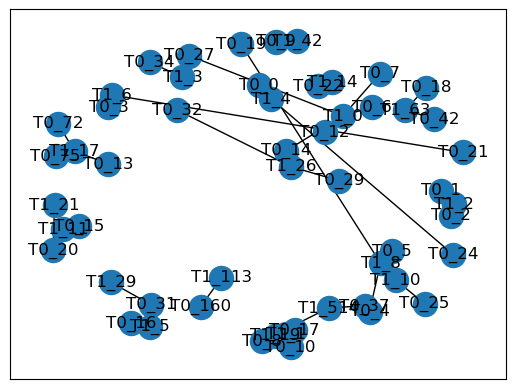

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
for score, things in zip(scores, strings):
    c1, c2 = things
    if c1 != '' and c2 != '':
        c1 = "T0_" + c1
        c2 = "T1_" + c2
        G.add_nodes_from([c1], bipartite = 0)
        G.add_nodes_from([c2], bipartite = 1)
        G.add_edge(c1, c2, weight = score)
    #else:
        #if c1 == '':
            #G.add_nodes_from(["T1_" + c2],bipartite=1)
        #else:
            #G.add_nodes_from(["T0_" + c1],bipartite=0)
nx.draw_networkx(G)
plt.show()

In [16]:
jaccards['T1'].shared_nodes

TypeError: list indices must be integers or slices, not str

In [38]:

ee, j = edge_based_matching(jaccards, threshold = 0.2)
eeee = {k: v for k, v in ee.items() if len(v) > 2}
for key in eeee.keys():
    print(key)
    
get_members(eeee['T0_C2'],jaccards)

T0_C17
T0_C10
T0_C2
T0_C15
T1_C24
T1_C25
T0_C3
T4_C35
T0_C22
T0_C5
T2_C38
weird. no shared nodes found in jacc 4.


{'blogdiva': 4,
 'ohiostudents': 4,
 'jasiri_x': 4,
 'sassycrass': 4,
 'sarahkendzior': 4,
 'jamilsmith': 4,
 'thenewjimcrow': 4,
 'jasmyne': 4,
 'lapdhq': 4,
 'autumnnalston': 4,
 'zerlinamaxwell': 4,
 'newblackman': 4,
 'aejohnsonphd': 4,
 'millionhoodies': 4,
 'youthjusticela': 4,
 'slmpd': 4,
 'wilgafney': 4,
 'dorothyeroberts': 4,
 'dreamdefenders': 4,
 'adv_project': 4,
 'reagangomez': 4,
 'bulldogshadow': 4,
 'show_me15': 4,
 'jbrownedianis': 4,
 'dviyer': 4,
 'aclu_mo': 4,
 'djolder': 4,
 'mrdaveyd': 4,
 'culturejedi': 4,
 'byp_100': 4,
 'juliacarriew': 4,
 'professorcrunk': 4,
 'shaunking': 4,
 'pastormykmac': 4,
 'jamilahlemieux': 4,
 '2liveunchained': 4,
 'rosaclemente': 4,
 'barbs73': 4,
 'changethenypd': 4,
 'penieljoseph': 4,
 'mspackyetti': 4,
 'joohyun_kang': 4,
 'nvlevy': 4,
 'theangryindian': 4,
 'jessienyc': 4,
 'raceforward': 4,
 'seanjjordan': 4,
 'revsekou': 4,
 'mariachappellen': 4,
 'rbraceysherman': 4,
 'rashadrobinson': 4,
 'reignofapril': 4,
 'malcolmlondon':

In [ ]:

threshold = 0.25
medusa = accumulate_matches(jaccards)
sorted_medusa = dict(sorted(medusa.items(), key=lambda x:x[1], reverse = True))
cleaned_medusa = {k:v for k,v in sorted_medusa.items() if v > threshold}



# names = ['cat','dog','mouse','fox','suslik']
# def edge_based_match(jaccards, threshold = 0.2):
#     medusa = accumulate_matches(jaccards)
#     edgelist = dict(sorted(medusa.items(), key=lambda x:x[1], reverse = True))
#     comms = dict()
#     ends = dict()
#     ctoo = dict()
#     G = nx.Graph()
#     for edge, score in edgelist.items():
#         c0, c1 = edge
#         if score > threshold:
#             if c0 in ctoo:
#                 ctoo[]
#             if c1 in ctoo:
#             comms.append(c0)
#             comms[c0] = (c0, c1)
#             G.add_edge(c0, c1, weight = score)
#     return G
# G = edge_based_match(jaccards)
# G.add_edge('T3_C14','T6_C4',weight=0.24)
# nx.draw_networkx(G)
# plt.show()

In [42]:
threshold = 0.2
ebm, i = edge_based_matching(jaccards, threshold = threshold, minis = True)
dsm, j = dynamic_sequential_matching(jaccards, threshold = threshold)
for key in ebm.keys():
    print(key)
    print(f"DSM: {dsm[key]}")
    print(f"EBM: {ebm[key]}")

T0_C17
DSM: ['T0_C17', 'T1_C19', 'T2_C16', 'T3_C12', 'T4_C25']
EBM: ['T0_C17', 'T1_C19', 'T2_C16', 'T3_C12', 'T4_C25']
T0_C10
DSM: ['T0_C10', 'T1_C1', 'T2_C12', 'T3_C1', 'T4_C1', 'T5_C6', 'T6_C0']
EBM: ['T0_C10', 'T1_C1', 'T2_C12', 'T3_C1', 'T4_C1', 'T5_C6', 'T6_C0']
T2_C23
DSM: ['T2_C23', 'T3_C16']
EBM: ['T2_C23', 'T3_C16']
T0_C2
DSM: ['T0_C2', 'T1_C2', 'T2_C2', 'T3_C0', 'T4_C2', 'T5_C7', 'T6_C21']
EBM: ['T0_C2', 'T1_C2', 'T2_C2', 'T3_C0', 'T4_C2', 'T5_C7', 'T6_C21']
T0_C15
DSM: ['T0_C15', 'T1_C11', 'T2_C21', 'T3_C28', 'T4_C52']
EBM: ['T0_C15', 'T1_C11', 'T2_C21', 'T3_C28', 'T4_C52']
T5_C60
DSM: ['T5_C60', 'T6_C35']
EBM: ['T5_C60', 'T6_C35']
T1_C24
DSM: ['T1_C24', 'T2_C10', 'T3_C51']
EBM: ['T1_C24', 'T2_C10', 'T3_C51']
T1_C25
DSM: ['T1_C25', 'T2_C22', 'T3_C31']
EBM: ['T1_C25', 'T2_C22', 'T3_C31']
T0_C0
DSM: ['T0_C0', 'T1_C4']
EBM: ['T0_C0', 'T1_C4']
T0_C3
DSM: ['T0_C3', 'T1_C6', 'T2_C0', 'T3_C4']
EBM: ['T0_C3', 'T1_C0', 'T1_C6', 'T2_C0', 'T3_C4']
T4_C35
DSM: ['T4_C35', 'T5_C44', 'T6_C